# Classical Shadows

## System

- H2 3-21G
- 8 qubits system with JW encoding, 6 with scBK

In [1]:
from tangelo.molecule_library import mol_H2_321g
from tangelo.toolboxes.ansatz_generator.qcc import QCC
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping

mol = mol_H2_321g

ferm_ham = mol.fermionic_hamiltonian

encoding = "scBK"
up_then_down = True
n_spinorbs = mol.n_active_sos
n_elecs = mol.n_active_electrons

qubit_ham = fermion_to_qubit_mapping(ferm_ham, encoding, n_spinorbitals=n_spinorbs, n_electrons=n_elecs, up_then_down=up_then_down)
print(len(qubit_ham.terms))
print(qubit_ham)

159
2.579949012375982 [] +
-0.037492080720818 [X0 X1 X2] +
0.020025172578589573 [X0 X1 X3] +
0.03277269075771461 [X0 X1 X3 X4] +
-0.020025172578589573 [X0 X1 X3 Z4] +
-0.03277269075771461 [X0 X1 Y3 Y4 Z5] +
0.006754493527852692 [X0 X1 Z3 Y4 Y5] +
0.006754493527852692 [X0 X1 X4 X5] +
0.03141738946123608 [X0 X1 Z4 X5] +
0.03141738946123608 [X0 X1 X5] +
0.0938037629995922 [X0 Y1 Y2] +
0.028545460511678965 [X0 Y1 Y2 X3 Y4 Y5] +
-0.028545460511678965 [X0 Y1 Y2 Y3 Y4 X5] +
-0.04160969890900229 [X0 Y1 Y2 Z3] +
0.019403339127070474 [X0 Y1 Y2 Z3 X4] +
-0.013922606768505517 [X0 Y1 Y2 Z3 Z4] +
0.019403339127070474 [X0 Y1 Y2 X4 Z5] +
0.05082457487428469 [X0 Y1 Y2 Z4 Z5] +
-0.033174242346539075 [X0 Y1 Y2 Z5] +
-0.02228270026844538 [X0 Z1 X3] +
-0.020025172578589573 [X0 Z1 X3 X4] +
0.02228270026844538 [X0 Z1 X3 Z4] +
0.020025172578589573 [X0 Z1 Y3 Y4 Z5] +
0.004162288539263883 [X0 Z1 Z3 Y4 Y5] +
0.004162288539263883 [X0 Z1 X4 X5] +
-0.023349354365647786 [X0 Z1 Z4 X5] +
-0.023349354365647786 [X0 Z1 X

- Introduce the QCC circuit

In [2]:
ansatz = QCC(mol, mapping=encoding, up_then_down=up_then_down)
ansatz.build_circuit()

- Minimizing classical parameters with VQESolver
- Extracting the optimized circuit

In [3]:
from tangelo.algorithms.variational import VQESolver

vqe = VQESolver({"qubit_hamiltonian": qubit_ham, "ansatz": ansatz.circuit})
vqe.build()
energy_ref = vqe.simulate()
print(f"Energy from statevector simulation: {energy_ref:.4f} hartree")

Energy from statevector simulation: -1.1475 hartree


## Visualization

- Visualization of the circuit with the qiskit module

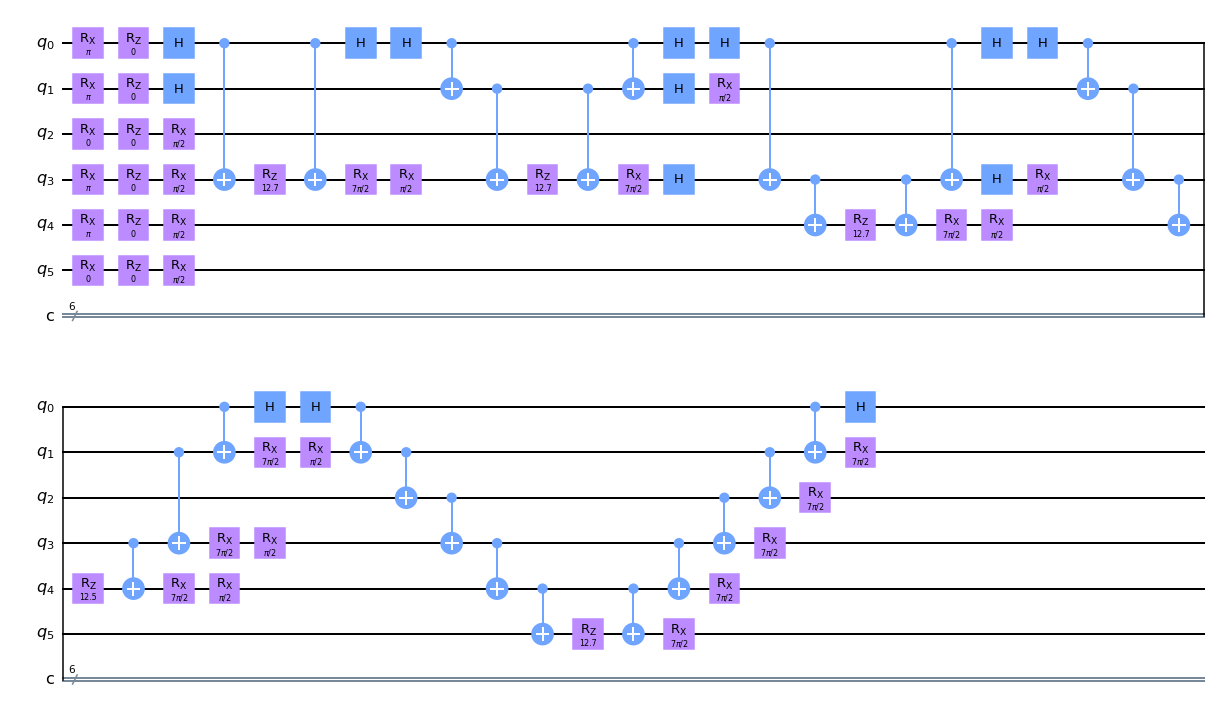

In [4]:
from tangelo.linq.translator import translate_qiskit

qiskit_circuit = translate_qiskit(vqe.optimal_circuit)
qiskit_circuit.draw(output="mpl")

## Measurement budget

- Talk about measurement budget = number of shots
- Number of shots vs accuracy
- Refer to Tangelo function for estimating the cost on real hardware

In [5]:
from tangelo.linq.qpu_connection import job_estimate

n_shots_budget = 1000

cost = job_estimate(vqe.optimal_circuit, n_shots_budget)
print(f"{n_shots_budget} shots through Braket IonQ: {cost['braket_ionq']:.2f}$ US")
print(f"{n_shots_budget} shots through Braket Rigetti: {cost['braket_rigetti']:.2f}$ US")

qemist_client python package not found (optional dependency for hardware experiment submission)
1000 shots through Braket IonQ: 10.30$ US
1000 shots through Braket Rigetti: 0.65$ US


## Reference values

- Without Noise, tell how it should be easy to test
- Equally distributed (easiest method)
- Research is done to allocate number of measurements depending of the coefficients / variances in a qubit Hamiltonian
- We provide qubit-wise commutativity at the time of writing this notebook

In [6]:
from tangelo.linq import Simulator
from tangelo.toolboxes.operators import QubitOperator

n_shots_per_term = round(n_shots_budget / len(qubit_ham.terms))
shots_backend = Simulator("cirq", n_shots=n_shots_per_term, noise_model=None)
print(f"{n_shots_per_term} shots per term when equally distributed.")

6 shots per term when equally distributed.


In [7]:
energy_shots = 0.
for term, coeff in qubit_ham.terms.items():
    qubit_term = QubitOperator(term, coeff)    
    energy_shots += shots_backend.get_expectation_value(qubit_term, vqe.optimal_circuit)

print(f"Energy from equally distributed shots simulation: {energy_shots:.4f} hartree")
print(f"Error vs statevector simulation: {abs(energy_ref-energy_shots):.3f} hartree")

Energy from equally distributed shots simulation: -1.0465 hartree
Error vs statevector simulation: 0.101 hartree


## Classical Shadows

- Talk about defining the backend (without or with noise)
- Tell about the warning if n_shots =/= 1 (explain the process behind)

In [8]:
cs_backend = Simulator("cirq", n_shots=1, noise_model=None)

## Randomized Single-Pauli Classical Shadows

- Summarize procedure of random sampling.

In [9]:
from tangelo.toolboxes.measurements import RandomizedClassicalShadow

random_cs = RandomizedClassicalShadow(vqe.optimal_circuit)
random_cs.build(n_shots_budget)
random_cs.simulate(cs_backend)

energy_random = random_cs.get_observable(qubit_ham)
print(f"Energy from randomized single-Pauli classical shadow: {energy_random:.4f} hartree")
print(f"Error vs statevector simulation: {abs(energy_ref-energy_random):.3f} hartree")

Energy from randomized single-Pauli classical shadow: -1.0131 hartree
Error vs statevector simulation: 0.134 hartree


## Derandomized Single-Pauli Classical Shadows

- Summarize procedure of derandom sampling.

In [10]:
from tangelo.toolboxes.measurements import DerandomizedClassicalShadow

derandom_cs = DerandomizedClassicalShadow(vqe.optimal_circuit)
derandom_cs.build(n_shots_budget, qubit_ham)
derandom_cs.simulate(cs_backend)

energy_derandom = derandom_cs.get_observable(qubit_ham)
print(f"Energy from derandomized single-Pauli classical shadow: {energy_derandom:.4f} hartree")
print(f"Error vs statevector simulation: {abs(energy_ref-energy_derandom):.3f} hartree")

Energy from derandomized single-Pauli classical shadow: -1.1578 hartree
Error vs statevector simulation: 0.010 hartree


## Adaptive Single-Pauli Classical Shadows

- Summarize procedure of adaptive sampling.

In [11]:
from tangelo.toolboxes.measurements import AdaptiveClassicalShadow

adaptive_cs = AdaptiveClassicalShadow(vqe.optimal_circuit)
adaptive_cs.build(n_shots_budget, qubit_ham)
adaptive_cs.simulate(cs_backend)

energy_adaptive = adaptive_cs.get_observable(qubit_ham)
print(f"Energy from adaptive single-Pauli classical shadow: {energy_adaptive:.4f} hartree")
print(f"Error vs statevector simulation: {abs(energy_ref-energy_adaptive):.3f} hartree")

Energy from adaptive single-Pauli classical shadow: -1.2486 hartree
Error vs statevector simulation: 0.101 hartree


## More data...

- There are some randomness in the classical shadows protocol. Therefore, your mileage may vary.
- We have ran 10 simulations, with JW and scBK encoding (8 or 6 qubits).
- Plot of abs(e_shadow - e_statevector).
![Alt Text](img/draft_classical_shadow_flavours.png "Plot")

- Discussion about the plot: classical shadow gives a probability of computing an observable within a given accuracy vs the number fo shots.
- Talk about the noise resistance -> classical shadows is more robust.

## Closing words

- Closing words...
- Summarize what has been learnt